In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.datasets import FacebookPagePage
from torch_geometric.utils import to_undirected, to_networkx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import random
import time
from utils import network_viz



## Check for GPU

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load the Facebook dataset
### Ref: https://snap.stanford.edu/data/facebook-large-page-page-network.html

In [13]:

dataset = FacebookPagePage(root='/tmp/FacebookPagePage')
data = dataset[0]

if data.is_undirected():
    print("Graph is loaded!")
    print("Graph is undirected")
else:
    print("Graph is directed")
    data.edge_index = to_undirected(data.edge_index, data.num_nodes)
    data.edge_attr = None

# Basic dataset information
print(f"Dataset: {dataset}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Is undirected: {data.is_undirected()}")

Graph is loaded!
Graph is undirected
Dataset: FacebookPagePage()
Number of nodes: 22470
Number of edges: 342004
Number of node features: 128
Is undirected: True


## Network visualization

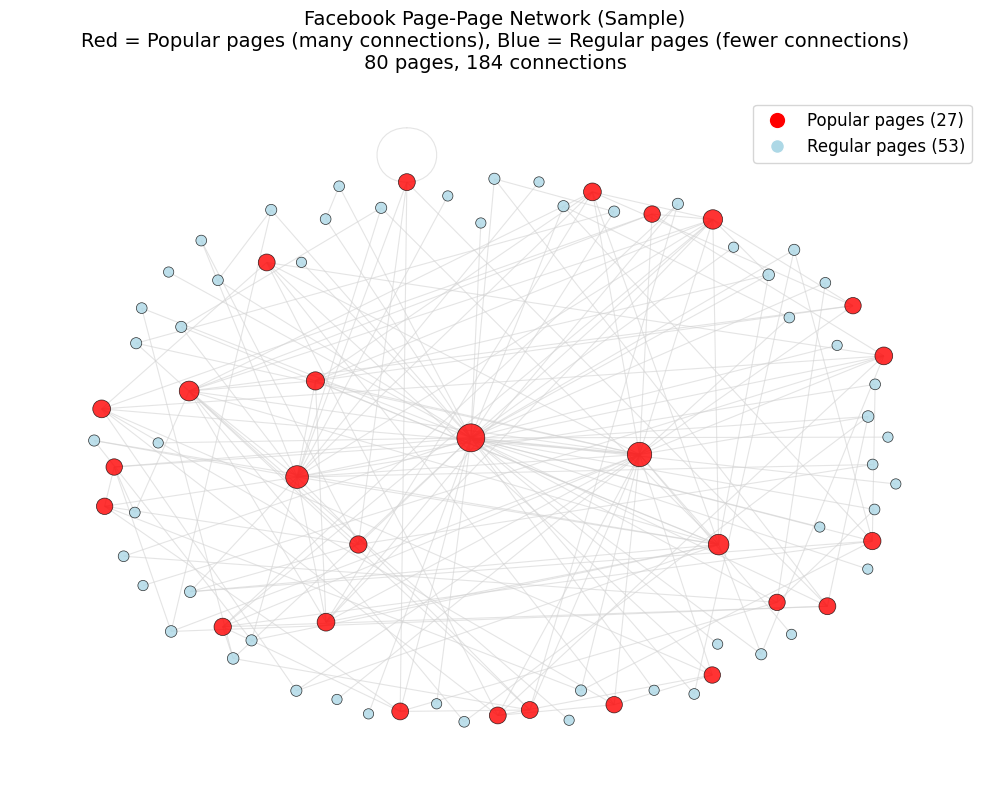


=== WHAT THIS SHOWS ===
✓ Facebook pages form a network - some are connected to others
✓ Popular pages (red) have many connections - they're 'hubs'
✓ Regular pages (blue) have fewer connections

Numbers:
• Popular pages average 9.6 connections each
• Regular pages average 2.1 connections each
• Most connected page has 38 connections


In [9]:
G_sub = network_viz(data)

## Analyze label distribution

In [10]:

print(f"\nLabel distribution:")
unique_labels, counts = torch.unique(data.y, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  Class {label.item()}: {count.item()} nodes ({count.item()/data.num_nodes*100:.1f}%)")



Label distribution:
  Class 0: 3327 nodes (14.8%)
  Class 1: 6495 nodes (28.9%)
  Class 2: 6880 nodes (30.6%)
  Class 3: 5768 nodes (25.7%)


In [14]:
def create_node_splits(num_nodes, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, seed=42):
    """Create random train/val/test splits for nodes"""
    assert train_ratio + val_ratio + test_ratio == 1.0
    
    # Set seed for reproducible splits
    torch.manual_seed(seed)
    
    # Create random permutation of node indices
    indices = torch.randperm(num_nodes)
    
    # Calculate split sizes
    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)
    
    # Create masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size + val_size]] = True
    test_mask[indices[train_size + val_size:]] = True
    
    return train_mask, val_mask, test_mask

# Move data to device
data.x = data.x.to(device)
data.y = data.y.to(device)

train_mask, val_mask, test_mask = create_node_splits(data.num_nodes)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)

print(f"Training nodes: {train_mask.sum().item()}")
print(f"Validation nodes: {val_mask.sum().item()}")
print(f"Test nodes: {test_mask.sum().item()}")

# Check label distribution in each split
for split_name, mask in [("Train", train_mask), ("Val", val_mask), ("Test", test_mask)]:
    split_labels = data.y[mask]  # No need for .to(device) since data.y is already on device
    unique_labels, counts = torch.unique(split_labels, return_counts=True)
    print(f"\n{split_name} split label distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  Class {label.item()}: {count.item()} nodes")

Training nodes: 13482
Validation nodes: 4494
Test nodes: 4494

Train split label distribution:
  Class 0: 2010 nodes
  Class 1: 3855 nodes
  Class 2: 4151 nodes
  Class 3: 3466 nodes

Val split label distribution:
  Class 0: 670 nodes
  Class 1: 1295 nodes
  Class 2: 1379 nodes
  Class 3: 1150 nodes

Test split label distribution:
  Class 0: 647 nodes
  Class 1: 1345 nodes
  Class 2: 1350 nodes
  Class 3: 1152 nodes


## Graph Attention Network (GAT)
<p align="center">
  <img src="gat_figure.jpg" width="800">
</p>
Ref: https://arxiv.org/abs/1710.10903

In [ ]:
class GATNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=8, dropout=0.6):
        super(GATNodeClassifier, self).__init__()
        
        # First GAT layer with multi-head attention
        self.conv1 = GATConv(
            in_channels, 
            hidden_channels, 
            heads=heads, 
            concat=True,
            dropout=dropout
        )

        # Second GAT layer with multi-head attention
        heads_2 = int(round((heads)/2))
        hidden_channels_2 = int(round(hidden_channels/2))
        self.conv2 = GATConv(
            hidden_channels * heads, 
            hidden_channels_2, 
            heads=heads_2, 
            concat=True, 
            dropout=dropout
        )
        
        # Output GAT layer for classification
        self.conv3 = GATConv(
            hidden_channels_2 * heads_2, 
            num_classes, 
            heads=1, 
            concat=False, 
            dropout=dropout
        )
        
        # Dropout layer
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Apply first GAT layer followed by ELU activation and dropout
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        # Apply second GAT layer followed by ELU activation and dropout
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        
        # Apply second GAT layer
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        
        return x
    
    def encode(self, x, edge_index):
        """Return node embeddings from the first layer (before classification)."""
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
    
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        return x

In [16]:
def train_and_evaluate_node_classifier(model, data, train_mask, val_mask, optimizer, epochs=200):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    eval_epochs = []
    best_val_acc = 0
    best_model_state = None
    data.edge_index = data.edge_index.to(device)
    
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index)
        
        # Compute loss only on training nodes
        loss = F.cross_entropy(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Evaluation
        if epoch % 10 == 0 or epoch == epochs:
            model.eval()
            with torch.no_grad():
                out = model(data.x, data.edge_index)
                
                # Training accuracy
                train_pred = out[train_mask].argmax(dim=1)
                train_acc = accuracy_score(data.y[train_mask].cpu(), train_pred.cpu())
                train_accuracies.append(train_acc)
                
                # Validation accuracy
                val_pred = out[val_mask].argmax(dim=1)
                val_acc = accuracy_score(data.y[val_mask].cpu(), val_pred.cpu())
                val_accuracies.append(val_acc)
                
                eval_epochs.append(epoch)
                
                print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
                
                # Save best model
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model_state = {
                        'model': model.state_dict(),
                        'epoch': epoch,
                        'val_acc': val_acc,
                        'train_acc': train_acc
                    }
    
    # Load best model for final evaluation
    if best_model_state:
        model.load_state_dict(best_model_state['model'])
        print(f"Best model from epoch {best_model_state['epoch']} with Val Acc: {best_model_state['val_acc']:.4f}")
    
    return model, train_losses, train_accuracies, val_accuracies, eval_epochs

## Hyperparameters

In [17]:
# Model hyperparameters
hidden_channels = 64
heads = 8
dropout = 0.2

# Training hyperparameters
epochs = 500
lr=0.001
weight_decay=5e-4


## Initiate GAT model

In [18]:
# Set up the model and optimizer
num_classes = data.y.max().item() + 1
model = GATNodeClassifier(
    in_channels=data.x.size(1),
    hidden_channels=hidden_channels,
    num_classes=num_classes,
    heads=heads,
    dropout=dropout
).to(device)


## Initiate optimizer

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

## Train the model

In [20]:
print("Starting training...")
start_time = time.time()
model, train_losses, train_accuracies, val_accuracies, eval_epochs = train_and_evaluate_node_classifier(
    model, data, train_mask, val_mask, optimizer, epochs=epochs
)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Starting training...
Epoch: 010, Loss: 0.4552, Train Acc: 0.8691, Val Acc: 0.8640
Epoch: 020, Loss: 0.3300, Train Acc: 0.9135, Val Acc: 0.9039
Epoch: 030, Loss: 0.2945, Train Acc: 0.9258, Val Acc: 0.9146
Epoch: 040, Loss: 0.2714, Train Acc: 0.9321, Val Acc: 0.9206
Epoch: 050, Loss: 0.2564, Train Acc: 0.9375, Val Acc: 0.9241
Epoch: 060, Loss: 0.2379, Train Acc: 0.9404, Val Acc: 0.9272
Epoch: 070, Loss: 0.2321, Train Acc: 0.9423, Val Acc: 0.9272
Epoch: 080, Loss: 0.2293, Train Acc: 0.9453, Val Acc: 0.9301
Epoch: 090, Loss: 0.2177, Train Acc: 0.9490, Val Acc: 0.9312
Epoch: 100, Loss: 0.2111, Train Acc: 0.9502, Val Acc: 0.9324
Epoch: 110, Loss: 0.2113, Train Acc: 0.9518, Val Acc: 0.9328
Epoch: 120, Loss: 0.2076, Train Acc: 0.9528, Val Acc: 0.9332
Epoch: 130, Loss: 0.2030, Train Acc: 0.9548, Val Acc: 0.9346
Epoch: 140, Loss: 0.2018, Train Acc: 0.9561, Val Acc: 0.9355
Epoch: 150, Loss: 0.1928, Train Acc: 0.9571, Val Acc: 0.9357
Epoch: 160, Loss: 0.1902, Train Acc: 0.9573, Val Acc: 0.9384
Epo

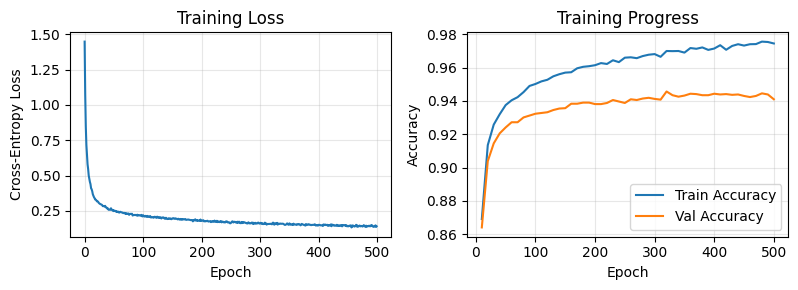

In [21]:
plt.figure(figsize=(8, 3))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.grid(alpha=0.3)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, train_accuracies, label='Train Accuracy')
plt.plot(eval_epochs, val_accuracies, label='Val Accuracy')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Final evaluation on test set

Test Accuracy: 0.9446

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.92      0.91       647
     Class 1       0.97      0.93      0.95      1345
     Class 2       0.94      0.96      0.95      1350
     Class 3       0.95      0.96      0.96      1152

    accuracy                           0.94      4494
   macro avg       0.94      0.94      0.94      4494
weighted avg       0.95      0.94      0.94      4494



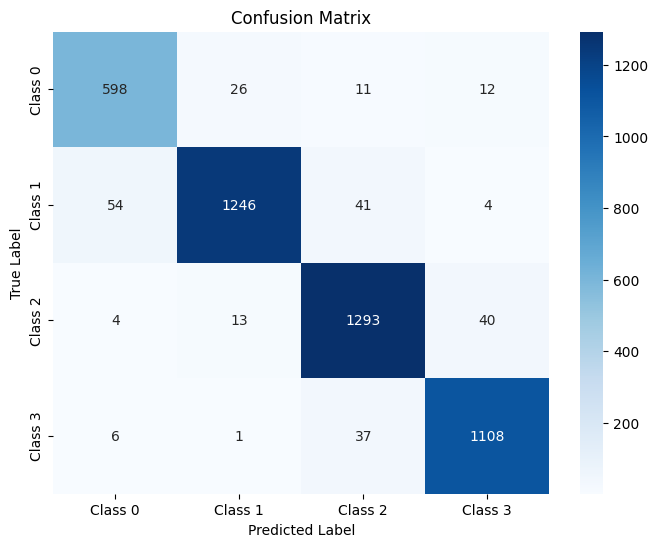

In [22]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    
    # Test predictions
    test_pred = out[test_mask].argmax(dim=1)
    test_acc = accuracy_score(data.y[test_mask].cpu(), test_pred.cpu())
    
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(data.y[test_mask].cpu(), test_pred.cpu(), 
                              target_names=[f'Class {i}' for i in range(num_classes)]))
    
    # Confusion matrix
    cm = confusion_matrix(data.y[test_mask].cpu(), test_pred.cpu())
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'Class {i}' for i in range(num_classes)],
                yticklabels=[f'Class {i}' for i in range(num_classes)])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


## T-SNE visualization of node embeddings

Total nodes: 22470
Test nodes: 4494
Test embedding shape: (4494, 128)
Number of unique labels in test set: 4
Computing t-SNE visualization...


/home/karthiksoman/anaconda3/envs/kg-gnn-tutorial/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE computation completed!


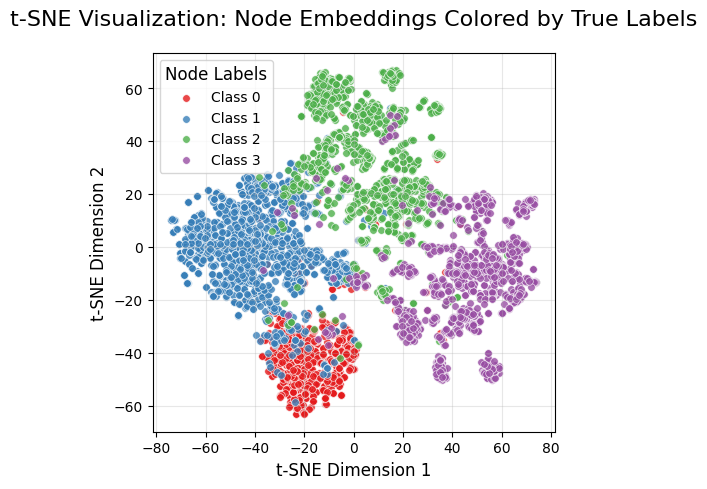

In [23]:
# t-SNE Visualization with Label-based Coloring

from sklearn.manifold import TSNE

# %%
# Get node embeddings from the trained model
model.eval()
with torch.no_grad():
    # Get embeddings from the first GAT layer (before classification)
    all_embeddings = model.encode(data.x, data.edge_index).cpu().numpy()
    all_labels = data.y.cpu().numpy()

# Filter for TEST nodes only
test_indices = test_mask.cpu().numpy()
test_embeddings = all_embeddings[test_indices]
test_labels = all_labels[test_indices]

print(f"Total nodes: {len(all_embeddings)}")
print(f"Test nodes: {len(test_embeddings)}")
print(f"Test embedding shape: {test_embeddings.shape}")
print(f"Number of unique labels in test set: {len(np.unique(test_labels))}")

# %%
# Apply t-SNE for dimensionality reduction
print("Computing t-SNE visualization...")
tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=30,
    n_iter=1000
)
embeddings_2d = tsne.fit_transform(test_embeddings)

print("t-SNE computation completed!")

# %%
# Create the visualization
plt.figure(figsize=(5, 5))

# Define distinct colors for each class
num_classes = len(np.unique(test_labels))
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
class_colors = colors[:num_classes]

# Plot each class separately for better legend control
for class_id in range(num_classes):
    class_mask = (test_labels == class_id)
    plt.scatter(
        embeddings_2d[class_mask, 0], 
        embeddings_2d[class_mask, 1],
        c=class_colors[class_id],
        label=f'Class {class_id}',
        s=30,
        alpha=0.8,
        edgecolors='white',
        linewidth=0.5
    )

# Customize the plot
plt.title('t-SNE Visualization: Node Embeddings Colored by True Labels', fontsize=16, pad=20)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Node Labels', title_fontsize=12, fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add some styling
plt.tight_layout()
plt.show()



## Random Forest vs GAT Comparison
### Train a Random Forest classifier using only node features and compares it with the GAT model

In [25]:
# Prepare data for Random Forest (using only node features, no graph structure)
print("Preparing data for Random Forest...")

# Extract node features and labels
X = data.x.cpu().numpy()  # Node features only
y = data.y.cpu().numpy()  # Node labels

# Use the same train/val/test splits as GAT
X_train = X[train_mask.cpu().numpy()]
y_train = y[train_mask.cpu().numpy()]

X_val = X[val_mask.cpu().numpy()]
y_val = y[val_mask.cpu().numpy()]

X_test = X[test_mask.cpu().numpy()]
y_test = y[test_mask.cpu().numpy()]

print(f"Feature shape: {X.shape}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")



Preparing data for Random Forest...
Feature shape: (22470, 128)
Training samples: 13482
Validation samples: 4494
Test samples: 4494


### Train Random Forest with hyperparameter tuning

In [26]:
print("Training Random Forest classifier...")

rf_params = [
    {'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    {'n_estimators': 200, 'max_depth': 15, 'random_state': 42},
    {'n_estimators': 300, 'max_depth': 20, 'random_state': 42},
    {'n_estimators': 100, 'max_depth': None, 'random_state': 42},
]

best_rf = None
best_val_acc = 0
rf_results = []

start_time = time.time()

for i, params in enumerate(rf_params):
    print(f"Testing RF configuration {i+1}/{len(rf_params)}: {params}")
    
    # Train Random Forest
    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)
    
    # Validate
    val_pred = rf.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    
    # Train accuracy
    train_pred = rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    rf_results.append({
        'params': params,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'model': rf
    })
    
    print(f"  Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_rf = rf

rf_training_time = time.time() - start_time
print(f"Random Forest training completed in {rf_training_time:.2f} seconds")
print(f"Best validation accuracy: {best_val_acc:.4f}")


Training Random Forest classifier...
Testing RF configuration 1/4: {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}
  Train Acc: 0.7803, Val Acc: 0.7354
Testing RF configuration 2/4: {'n_estimators': 200, 'max_depth': 15, 'random_state': 42}
  Train Acc: 0.8633, Val Acc: 0.7793
Testing RF configuration 3/4: {'n_estimators': 300, 'max_depth': 20, 'random_state': 42}
  Train Acc: 0.9230, Val Acc: 0.7931
Testing RF configuration 4/4: {'n_estimators': 100, 'max_depth': None, 'random_state': 42}
  Train Acc: 1.0000, Val Acc: 0.8184
Random Forest training completed in 32.37 seconds
Best validation accuracy: 0.8184


### Evaluate Random Forest on test set

In [ ]:

print("\nEvaluating Random Forest on test set...")
rf_test_pred = best_rf.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")

# Get Random Forest probabilities for confidence analysis
rf_test_proba = best_rf.predict_proba(X_test)
rf_test_confidence = np.max(rf_test_proba, axis=1)

# Get GAT results for comparison (re-evaluate to ensure consistency)
print("Re-evaluating GAT model...")
model.eval()
with torch.no_grad():
    gat_out = model(data.x, data.edge_index)
    gat_test_pred = gat_out[test_mask].argmax(dim=1).cpu().numpy()
    gat_test_acc = accuracy_score(y_test, gat_test_pred)
    
    # Get GAT probabilities and confidence
    gat_test_proba = torch.softmax(gat_out[test_mask], dim=1).cpu().numpy()
    gat_test_confidence = np.max(gat_test_proba, axis=1)

print(f"GAT Test Accuracy: {gat_test_acc:.4f}")



Evaluating Random Forest on test set...
Random Forest Test Accuracy: 0.8191
Re-evaluating GAT model...
GAT Test Accuracy: 0.9446


### Comparison visualization

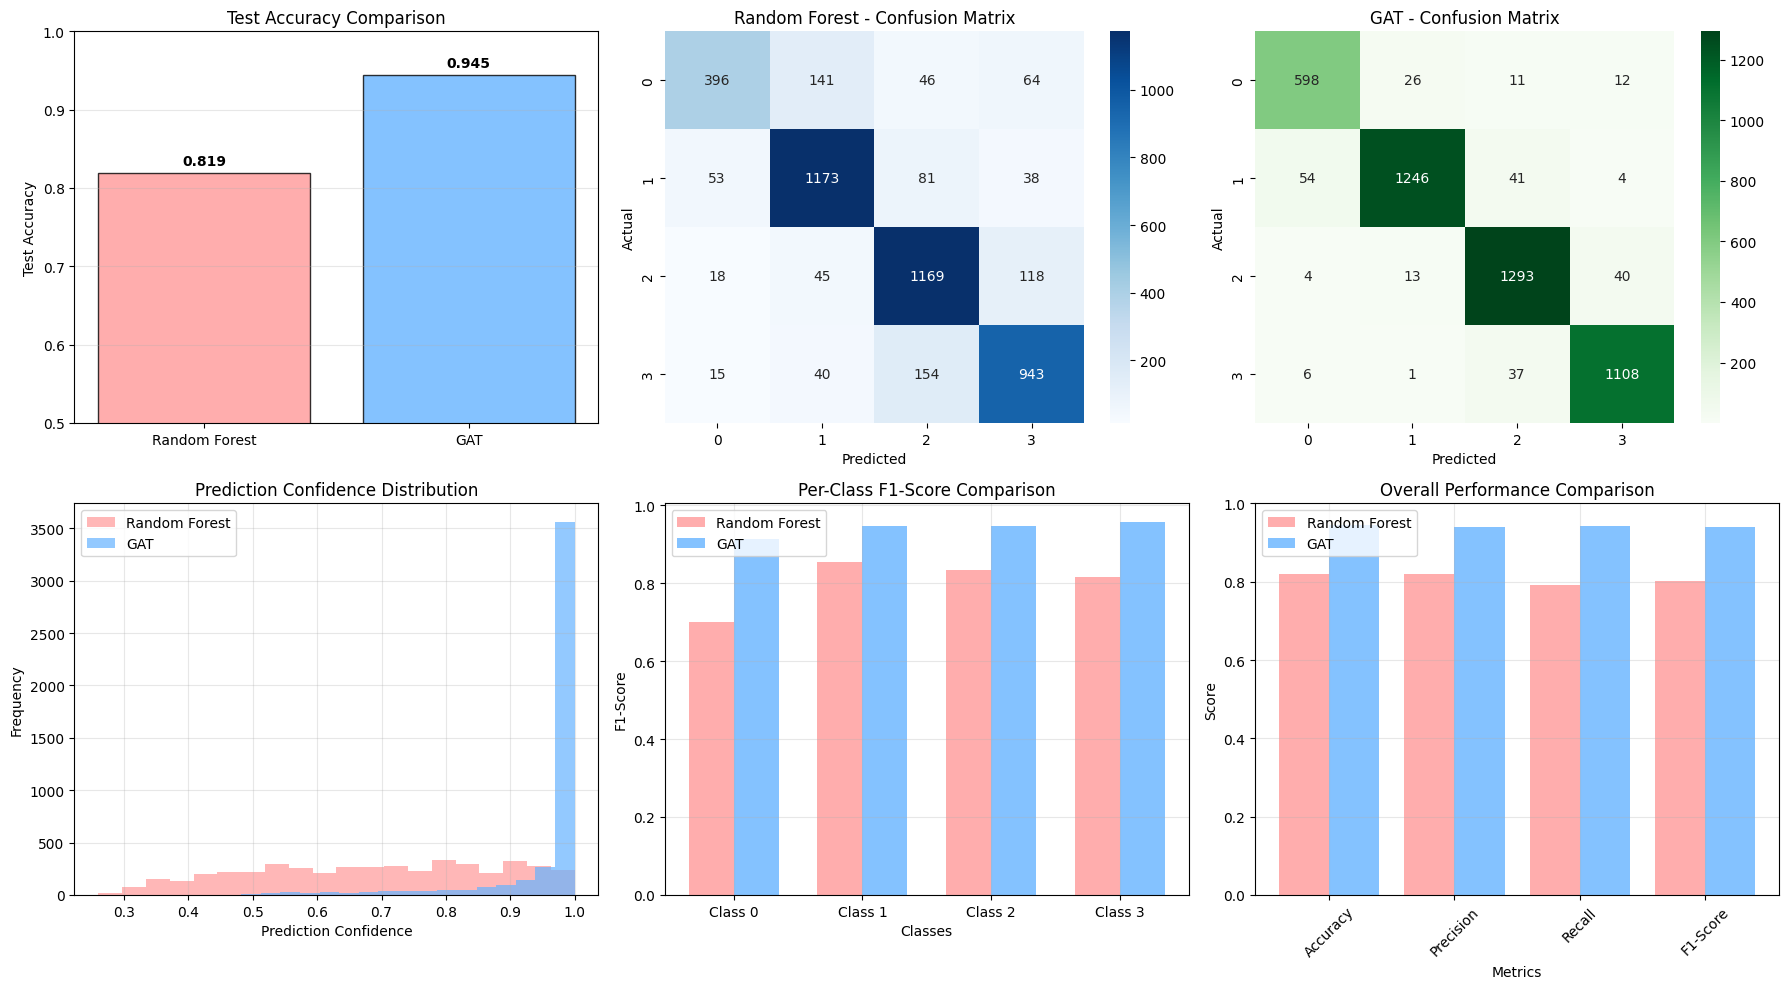


DETAILED COMPARISON RESULTS

📊 ACCURACY COMPARISON:
Random Forest Test Accuracy: 0.8191
GAT Test Accuracy:          0.9446
Improvement:                +0.1255 (+15.3%)

🔍 CONFIDENCE ANALYSIS:
Random Forest Avg Confidence: 0.6851
GAT Avg Confidence:          0.9625

📈 PER-CLASS F1-SCORES:
Class    RF F1    GAT F1   Improvement 
----------------------------------------
0        0.702    0.914    +0.212
1        0.855    0.947    +0.092
2        0.835    0.947    +0.112
3        0.815    0.957    +0.142

🎯 KEY INSIGHTS:
✅ GAT outperforms Random Forest by 15.3 percentage points!
   This demonstrates the value of incorporating graph structure.
   🚀 Significant improvement! Graph structure is very informative.

💡 WORKSHOP TAKEAWAYS:
• Random Forest: Uses only node features (ignores graph structure)
• GAT: Uses both node features AND graph structure
• The difference shows the value of graph neural networks!
• Consider both approaches in real-world applications


In [31]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Accuracy Comparison
methods = ['Random Forest', 'GAT']
accuracies = [rf_test_acc, gat_test_acc]
colors = ['#ff9999', '#66b3ff']

axes[0, 0].bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy Comparison')
axes[0, 0].set_ylim([0.5, 1])
axes[0, 0].grid(axis='y', alpha=0.3)

# Add accuracy values on bars
for i, acc in enumerate(accuracies):
    axes[0, 0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontweight='bold')

# 2. Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_test_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Random Forest - Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. Confusion Matrix - GAT  
cm_gat = confusion_matrix(y_test, gat_test_pred)
sns.heatmap(cm_gat, annot=True, fmt='d', cmap='Greens', ax=axes[0, 2])
axes[0, 2].set_title('GAT - Confusion Matrix')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# 4. Confidence Comparison
axes[1, 0].hist(rf_test_confidence, bins=20, alpha=0.7, label='Random Forest', color='#ff9999')
axes[1, 0].hist(gat_test_confidence, bins=20, alpha=0.7, label='GAT', color='#66b3ff')
axes[1, 0].set_xlabel('Prediction Confidence')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Prediction Confidence Distribution')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Per-class Performance Comparison
from sklearn.metrics import classification_report

# Get per-class metrics for both models
rf_report = classification_report(y_test, rf_test_pred, output_dict=True)
gat_report = classification_report(y_test, gat_test_pred, output_dict=True)

# Extract F1-scores for each class
num_classes = len(np.unique(y_test))
class_names = [f'Class {i}' for i in range(num_classes)]
rf_f1_scores = [rf_report[str(i)]['f1-score'] for i in range(num_classes)]
gat_f1_scores = [gat_report[str(i)]['f1-score'] for i in range(num_classes)]

x = np.arange(len(class_names))
width = 0.35

axes[1, 1].bar(x - width/2, rf_f1_scores, width, label='Random Forest', color='#ff9999', alpha=0.8)
axes[1, 1].bar(x + width/2, gat_f1_scores, width, label='GAT', color='#66b3ff', alpha=0.8)
axes[1, 1].set_xlabel('Classes')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('Per-Class F1-Score Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(class_names)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Model Comparison Summary
# Create a summary table visualization
comparison_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [
        rf_test_acc,
        rf_report['macro avg']['precision'],
        rf_report['macro avg']['recall'],
        rf_report['macro avg']['f1-score']
    ],
    'GAT': [
        gat_test_acc,
        gat_report['macro avg']['precision'],
        gat_report['macro avg']['recall'],
        gat_report['macro avg']['f1-score']
    ]
}

# Create comparison table as a bar plot
x_pos = np.arange(len(comparison_metrics['Metric']))
rf_values = comparison_metrics['Random Forest']
gat_values = comparison_metrics['GAT']

axes[1, 2].bar(x_pos - 0.2, rf_values, 0.4, label='Random Forest', color='#ff9999', alpha=0.8)
axes[1, 2].bar(x_pos + 0.2, gat_values, 0.4, label='GAT', color='#66b3ff', alpha=0.8)
axes[1, 2].set_xlabel('Metrics')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Overall Performance Comparison')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(comparison_metrics['Metric'], rotation=45)
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)
axes[1, 2].set_ylim([0, 1])

plt.tight_layout()
plt.show()


print("\n" + "="*60)
print("DETAILED COMPARISON RESULTS")
print("="*60)

print(f"\n📊 ACCURACY COMPARISON:")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")
print(f"GAT Test Accuracy:          {gat_test_acc:.4f}")
print(f"Improvement:                {gat_test_acc - rf_test_acc:+.4f} ({((gat_test_acc-rf_test_acc)/rf_test_acc)*100:+.1f}%)")

print(f"\n🔍 CONFIDENCE ANALYSIS:")
print(f"Random Forest Avg Confidence: {np.mean(rf_test_confidence):.4f}")
print(f"GAT Avg Confidence:          {np.mean(gat_test_confidence):.4f}")

print(f"\n📈 PER-CLASS F1-SCORES:")
print(f"{'Class':<8} {'RF F1':<8} {'GAT F1':<8} {'Improvement':<12}")
print("-" * 40)
for i in range(num_classes):
    improvement = gat_f1_scores[i] - rf_f1_scores[i]
    print(f"{i:<8} {rf_f1_scores[i]:<8.3f} {gat_f1_scores[i]:<8.3f} {improvement:+.3f}")



# Summary and interpretation
print(f"\n🎯 KEY INSIGHTS:")
print("="*50)

if gat_test_acc > rf_test_acc:
    improvement = (gat_test_acc - rf_test_acc)/rf_test_acc * 100
    print(f"✅ GAT outperforms Random Forest by {improvement:.1f} percentage points!")
    print("   This demonstrates the value of incorporating graph structure.")
    
    if improvement > 5:
        print("   🚀 Significant improvement! Graph structure is very informative.")
    elif improvement > 2:
        print("   📈 Moderate improvement. Graph structure provides useful signals.")
    else:
        print("   📊 Small improvement. Node features are quite informative on their own.")
        
else:
    print("❌ Random Forest performs better or equally well.")
    print("   This suggests that:")
    print("   • Node features alone are very informative")
    print("   • Graph structure may not be as important for this task")
    print("   • GAT model might need hyperparameter tuning")

print(f"\n💡 WORKSHOP TAKEAWAYS:")
print("• Random Forest: Uses only node features (ignores graph structure)")
print("• GAT: Uses both node features AND graph structure")
print("• The difference shows the value of graph neural networks!")
print("• Consider both approaches in real-world applications")